In [18]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transactions = pd.read_csv('transactions.csv')

In [3]:
transactions.amount = transactions.amount.apply(lambda x: round(x/11.2296))

In [4]:
train_transactions = transactions[transactions.amount < 0].copy()
train_transactions['day'] = train_transactions.tr_datetime.apply(lambda dt: dt.split()[0]).astype(int)

* 6010, 6011 - снятие налички;
* 5411 - супермаркеты
* 4814 - звонки
* 4829 - переводы

In [6]:
test_transactions = pd.DataFrame(columns=train_transactions.mcc_code.unique(), 
                                 index=np.arange(1, 31) + train_transactions.day.max())
test_transactions = test_transactions.unstack().reset_index().dropna(axis=1)
test_transactions.columns = ['mcc_code', 'day']

In [7]:
train_grid = pd.DataFrame(columns=train_transactions.mcc_code.unique(), 
                          index=train_transactions.day.unique())
train_grid = train_grid.unstack().reset_index().dropna(axis=1)
train_grid.columns = ['mcc_code', 'day']

In [8]:
for tr_table in [train_transactions, test_transactions, train_grid]:
    tr_table['week_num'] = tr_table['day'] // 7
    tr_table['week_day'] = tr_table['day'] % 7
    tr_table['month_num'] = tr_table['day'] // 30
    tr_table['month_day'] = tr_table['day'] % 30

In [9]:
train_transactions = \
    pd.merge(train_grid,
             train_transactions.groupby(['day', 'week_num', 'week_day', 'month_num', 'month_day', 'mcc_code'])[['amount']]\
                 .sum().reset_index(),
             how='left').fillna(0)

In [49]:
test_transactions = test_transactions.drop(["week_num", "week_day", "month_num", "month_day"], axis=1)


# Explore how amount graph depends from day, week, month

In [19]:
nalik = train_transactions[train_transactions.mcc_code == 6011]
nalik.amount = nalik.amount.apply(lambda x: -x)

In [20]:
nalik.shape

(457, 7)

In [21]:
nalik = nalik.sort_values("day", ascending=True)

In [22]:
by_day = nalik.set_index(nalik.day).drop(["day"], axis=1)

### Plotting by day

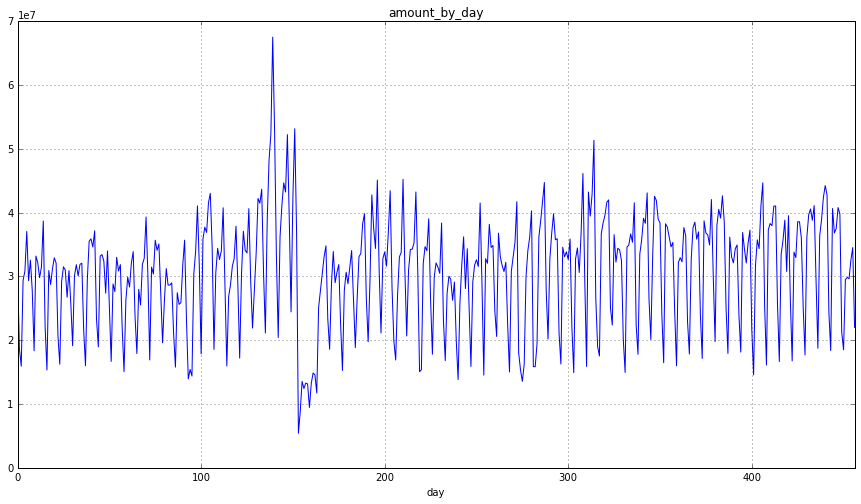

In [23]:
by_day.amount.plot(figsize=(15,8), grid=True, title="amount_by_day")

In [95]:
res_df = pd.DataFrame(columns=["mcc_code", "day", "volume"])

In [97]:
%%time
for mcc in train_transactions.mcc_code.unique():
    print mcc
    nalik = train_transactions[train_transactions.mcc_code == mcc]
    nalik.amount = nalik.amount.apply(lambda x: -x)
    nalik = nalik.sort_values("day", ascending=True)
    by_day = nalik.set_index(nalik.day).drop(["day"], axis=1)
    by_day = by_day.amount
    by_day.index = pd.to_datetime(by_day.index, unit='D')
    arma_mod = sm.tsa.ARMA(by_day, (15,0)).fit()
    predict_dynam = arma_mod.predict('1971-04-03', '1971-05-02', dynamic=True)
    data_mcc = pd.DataFrame(data=predict_dynam, columns=["volume"]).reset_index().drop(["index"], axis=1)
    test_tr = test_transactions[test_transactions.mcc_code == mcc][["mcc_code", "day"]].reset_index().drop(["index"], axis=1)
    res_mcc = pd.concat([test_tr, data_mcc], axis=1)

    res_df = pd.concat([res_df, res_mcc], axis=0)

4814
4829
5499
5541
5200
5732
6011
5331
5912
5411
5812
5719
6010
5722
5621
5814
5921
5941
5691
5813
5211
4812
5945
5983
5999
5943
5533
6300
7832
8099
5992
3501
7997
5641
4722
5661
5651
7011
5699
5942
7298
7999
5712
5511
5422
5399
4900
7538
5949
5977
5948
5631
5311
5462
4112
8999
8021
5714
5251
4789
7542
5947
3000
8043
5944
5734
5611
5532
4816
7311
5655
6051
6012
7994
5995
5309
5964
8299
8244
4111
4511
9399
5441
7922
5261
7699
7995
7629
5816
5735
5039
5300
5199
4121
5065
7399
7299
8011
7230
9222
5946
5131
5994
5231
8071
5094
5047
5072
7210
5976
5045
7932
4215
5542
5099
5713
4899
7933
5681
5193
1711
6211
8398
5599
5993
8062
5169
4214
5733
5013
7221
5571
6536
7993
5971
5968
7372
5074
5044
5811
5111
8641
7512
7523
9311
8220
7991


/Users/d.parpulov/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


7996
4784
5931
7841
3351
4411
1799
5192
5122
742
6513
7278
5969
5970
4131
5965
7395
5950
5085
7273
5137
5310
7531
7829
7375
2741
5172
8699
7216
5451
5967
7338
9402
5697
1731
5940
9211
CPU times: user 2h 24min 19s, sys: 4min 43s, total: 2h 29min 3s
Wall time: 4h 42min 11s


In [104]:
res = res_df.reset_index().drop(["index"], axis=1)

In [106]:
res.volume = res.volume.apply(lambda x: x*11.2296)

In [117]:
res.day = res.day.apply(lambda x: int(x))
res.mcc_code = res.mcc_code.apply(lambda x: int(x))

res.head()

,mcc_code,day,volume
0,4814,457,9.282203e+06
1,4814,458,1.209837e+07
2,4814,459,1.497975e+07
3,4814,460,1.109587e+07
4,4814,461,9.963222e+06


In [118]:
res.to_csv("arima_all.csv", index=None)

In [50]:
test_transactions.head()

,mcc_code,day
0,4814,457
1,4814,458
2,4814,459
3,4814,460
4,4814,461


In [ ]:
test_transactions[['mcc_code', 'day', 'volume']].to_csv('baseline_b.csv', index=False)